## File with AIMA functions

In file `search_mod.py` we have some functions implemented by AIMA. To run the code in this notebook, it is needed to run the following cell to import the functions from the file.


In [9]:
# Import implementation of the abstract class that represents a problem to be solved
from search import Problem

# Import search algorithms
from search import depth_first_graph_search, breadth_first_graph_search, astar_search

# Import functions that facilitate the representation of the path to the solution
from aux_functions import (
    read_input_file,
    distance_between_orientations,
    run_search_algorithm,
    generate_random_maps,
    get_states_h2,
    plot_path_in_map,
)

## Reading the input


In [10]:
n_rows, n_cols, map_costs, initial, goal = read_input_file("exampleMap.txt")
print(f"Number of rows: {n_rows}")
print(f"Number of columns: {n_cols}")
print(f"Map costs: {map_costs}")
print(f"Initial position: {initial}")
print(f"Goal position: {goal}")

Number of rows: 3
Number of columns: 4
Map costs: [[3, 2, 4, 1], [2, 3, 1, 2], [1, 4, 2, 3]]
Initial position: (0, 3, 0)
Goal position: (1, 2, 8)


## Definition of the problem

We extend the class `Problem` implemented by AIMA to define the problem for this task, called: `MinningProblem`. To achieve this, we define the following methods:

- `__init__(self, initial, goal)`: This method initializes the problem with the initial state and the goal state.
- `is_valid_state(self, state)`: This method checks if a given state is valid, taking into account the number of rows and columns of the problem.
- `actions(self, state)`: This method returns the possible actions that can be taken from a given state. The actions will consists on the next states that can be reached from the current state.
- `result(self, state, action)`: This method returns the state that results from taking an action from a given state (in this case, the action is the next state).
- `h(self, node)`: This method returns the heuristic value of a given node.


In [11]:
class MinningProblem(Problem):
    """We have a board with rows and columns and a robot that can move in 8 directions."""

    def __init__(self, rows, columns, map, initial, goal):
        self.map = map
        self.rows, self.columns = rows, columns
        self.initial, self.goal = initial, goal

    def is_valid_state(self, state):
        """Check that the given state is a possible state given a board with rows and columns."""
        return all(x >= 0 for x in state) and state[0] < self.rows and state[1] < self.columns and state[2] < 8

    def actions(self, state):
        """Return the possible movements of the robot given a state"""
        # Get the orientation of the robot
        orientation = state[2]
        # We always can rotate the robot 45 degrees to the left and to the right
        movements = ["turn_left", "turn_right"]
        # The startegy to move forward the robot is to move
        # it always and then check if new_state is valid
        # Calculate the new position on axis y
        new_state = list(state)
        if orientation >= 7 or orientation <= 1:
            new_state[0] = state[0] - 1
        elif orientation >= 3 and orientation <= 5:
            new_state[0] = state[0] + 1
        # Calculate the new position on axis x
        if orientation >= 1 and orientation <= 3:
            new_state[1] = state[1] + 1
        elif orientation >= 5 and orientation <= 7:
            new_state[1] = state[1] - 1

        if self.is_valid_state(new_state):
            movements.append("move_forward")

        return movements

    def result(self, state, action):
        """Move the robot to the next state"""
        if action == "turn_left":
            return (state[0], state[1], (state[2] - 1) % 8)
        elif action == "turn_right":
            return (state[0], state[1], (state[2] + 1) % 8)
        elif action == "move_forward":
            new_state = list(state)
            if state[2] >= 7 or state[2] <= 1:
                new_state[0] = state[0] - 1
            elif state[2] >= 3 and state[2] <= 5:
                new_state[0] = state[0] + 1
            if state[2] >= 1 and state[2] <= 3:
                new_state[1] = state[1] + 1
            elif state[2] >= 5 and state[2] <= 7:
                new_state[1] = state[1] - 1
            return tuple(new_state)
        return action

    def goal_test(self, state):
        """Check if the current state is the goal state"""
        return state[:2] == self.goal[:2]

    def path_cost(self, c, state1, action, state2):
        """Return the cost of a solution path that arrives at state2 from
        state1 via action, assuming cost c to get up to state1."""
        # We have to distinguish when the state2 is reached by
        # a rotation of the robot or by a movement of the robot
        if action == "turn_left" or action == "turn_right":
            return c + 1
        else:
            return c + self.map[state2[0]][state2[1]]

    def h1(self, node):
        """
        Distance of Mahalanobis between the current state and the goal state.
        To elaborate this heuristic, we supose that all the positions of the board
        has cost 1 and the robot can rotate without cost. Also, we suppose that
        the robot only has to move forward in one axis to reach the goal state.
        """
        return max(abs(self.goal[0] - node.state[0]), abs(self.goal[1] - node.state[1]))

    def h2(self, node):
        """For this heurisit we suppose that all the positions of the board
        has cost 1.
        """
        if self.goal_test(node.state):
            return 0

        orientation = node.state[2]

        movements_y = self.goal[0] - node.state[0]
        movements_x = self.goal[1] - node.state[1]

        # Calculate the directions to move the robot to the goal state
        # in both axis
        orientation_y = 4 if movements_y > 0 else 0
        orientation_x = 2 if movements_x > 0 else 6

        # Calculate absolute values:
        movements_y = abs(movements_y)
        movements_x = abs(movements_x)
        # Calculate the number of movements in diagonal and straight
        diagonal_movements = min(movements_y, movements_x)
        straight_movements = abs(movements_y - movements_x)

        # We have two options: rotate the robot to move diagonally towards
        # the goal state, or rotate the robot to move along the axis where
        # the robot is furthest from the goal state.
        if movements_y > movements_x:
            straight_orientation = orientation_y
        else:
            straight_orientation = orientation_x

        if orientation_y == 0 and orientation_x == 6:  # special case
            diagonal_orientation = 7
        else:
            diagonal_orientation = (orientation_y + orientation_x) // 2

        number_rotations_straight = (
            distance_between_orientations(orientation, straight_orientation) if straight_movements > 0 else 0
        )
        number_rotations_diagonal = (
            distance_between_orientations(orientation, diagonal_orientation) if diagonal_movements > 0 else 0
        )

        number_rotations = max(number_rotations_straight, number_rotations_diagonal)
        total_cost = number_rotations + diagonal_movements + straight_movements

        return total_cost

    def h(self, node):
        return self.h2(node)

In [12]:
n_rows, n_cols, map_costs, initial, goal = read_input_file("exampleMap.txt")
mp = MinningProblem(n_rows, n_cols, map_costs, initial, goal)
[mp.result(initial, action) for action in mp.actions(initial)]

[(0, 3, 7), (0, 3, 1)]

## Trying the search algorithms


How to use the functions to run the algorithms and representate the followed path in the grid.


In [13]:
sol = breadth_first_graph_search(mp)
print(f"Cost of the solution: {sol.path_cost}")
print(f"Number of actions: {len(sol.path())}")
print(f"Actions: {sol.solution()}")
print(f"States: {[node.state for node in sol.path()]}")

Cost of the solution: 4
Number of actions: 5
Actions: ['turn_left', 'turn_left', 'turn_left', 'move_forward']
States: [(0, 3, 0), (0, 3, 7), (0, 3, 6), (0, 3, 5), (1, 2, 5)]


In [14]:
sol = run_search_algorithm(mp, breadth_first_graph_search, verbose=True)

#################################
Running breadth_first_graph_search algorithm
#################################

Depth (d): 4
Path cost (g): 4

Path actions:
State 0: (0, 3, 0) (initial state)
Action 0: turn_left
State 1: (0, 3, 7)
Action 1: turn_left
State 2: (0, 3, 6)
Action 2: turn_left
State 3: (0, 3, 5)
Action 3: move_forward
State 4: (1, 2, 5)

Total number of items in explored list: 6
Total number of items in frontier: 3


## Running experiments

We have a function called `run_experiments` that runs the search algorithms for a given problem and returns the path followed by the algorithm. The return of this function is a `list` that contains one `dictionary` for each algorithm. Each `dictionary` contains the 10 solutions for the 10 different maps of each size (3, 5, 7, 9) of each algorithm. The keys of the `dictionary` are the names of the maps and the values are the solutions returned by the algorithms.

It is also needed to include `#E`: "total number of explored (expanded) nodes throughout the corresponding algorithm’s execution" and `#F`: "is the final number of nodes stored in the explored (expanded) list
at the end of the execution" in the table of results.


In [15]:
import pandas as pd
import numpy as np


def run_experiments(map_sizes=[3, 5, 7, 9]):
    """Run the experiments for the different search algorithms and map sizes."""
    algorithms = {
        "Breadth-first": breadth_first_graph_search,
        "Depth-first": depth_first_graph_search,
        "A* (h1)": lambda mp: astar_search(mp, mp.h1),
        "A* (h2)": lambda mp: astar_search(mp, mp.h2),
    }

    initial_state = (0, 0, 0)
    results = []

    for size in map_sizes:
        # Generate random maps and define the goal state
        maps = generate_random_maps(size, 10)
        goal = (size - 1, size - 1, 8)

        # Initialize dictionary to store the results of each algorithm
        results_size = {algo: np.zeros((10, 4)) for algo in algorithms}

        for i, map_data in enumerate(maps):
            mp = MinningProblem(size, size, map_data, initial_state, goal)

            # Run the search algorithms
            for algorithm_name, algorithm_fn in algorithms.items():
                solution = algorithm_fn(mp)
                results_size[algorithm_name][i] = (
                    solution.depth,
                    solution.path_cost.item(),
                    solution.explored_items,
                    solution.frontier_items,
                )

        results.append(results_size)

    return results


def print_tables(results, map_sizes=[3, 5, 7, 9], style="markdown"):
    """Prints the tables of the results of the experiments in markdown format."""
    assert len(results) == len(map_sizes), "The length of results and map_sizes should be the same."
    bfs = "Breadth-first"
    dfs = "Depth-first"
    a_star_h1 = "A* (h1)"
    a_star_h2 = "A* (h2)"

    for map_size, res_size in zip(map_sizes, results):
        print(f"\n#### Comparative table of performance of search methods in the map of dimension {map_size}")
        table = pd.DataFrame(
            {
                bfs: np.mean(res_size[bfs], axis=0),
                dfs: np.mean(res_size[dfs], axis=0),
                a_star_h1: np.mean(res_size[a_star_h1], axis=0),
                a_star_h2: np.mean(res_size[a_star_h2], axis=0),
            },
            index=["d", "g", "#E", "#F"],
        )
        # Transpose the table to make it easier to read
        transposed_table = table.transpose()
        if style == "markdown":
            print(transposed_table.to_markdown())
        elif style == "html":
            print(transposed_table.to_html())
        elif style == "latex":
            print(transposed_table.to_latex())
        else:
            print(transposed_table)

In [16]:
results = run_experiments(map_sizes=[3, 5, 7, 9])
print_tables(results, map_sizes=[3, 5, 7, 9], style="markdown")


#### Comparative table of performance of search methods in the map of dimension 3
|               |   d |    g |   #E |   #F |
|:--------------|----:|-----:|-----:|-----:|
| Breadth-first | 5   | 12.7 | 10   |  6   |
| Depth-first   | 8   | 25.5 |  8   |  8   |
| A* (h1)       | 5.6 | 12.4 | 30.7 | 10   |
| A* (h2)       | 5.6 | 12.4 | 19.5 | 11.3 |

#### Comparative table of performance of search methods in the map of dimension 5
|               |    d |    g |    #E |   #F |
|:--------------|-----:|-----:|------:|-----:|
| Breadth-first |  7   | 22.5 |  33   | 28   |
| Depth-first   | 12   | 39   |  12   | 16   |
| A* (h1)       | 10.1 | 19.5 | 122.9 | 23.7 |
| A* (h2)       | 10.1 | 19.5 |  95.7 | 28.7 |

#### Comparative table of performance of search methods in the map of dimension 7
|               |    d |    g |    #E |   #F |
|:--------------|-----:|-----:|------:|-----:|
| Breadth-first |  9   | 28   | 106   | 59   |
| Depth-first   | 16   | 64.7 |  16   | 24   |
| A* (h1)  

### Results

#### Comparative table of performance of search methods in the map of dimension 3

|               |   d |    g |   #E |   #F |
| :------------ | --: | ---: | ---: | ---: |
| Breadth-first |   5 | 12.7 |   10 |    6 |
| Depth-first   |   8 | 25.5 |    8 |    8 |
| A\* (h1)      | 5.6 | 12.4 | 30.7 |   10 |
| A\* (h2)      | 5.6 | 12.4 | 19.5 | 11.3 |

#### Comparative table of performance of search methods in the map of dimension 5

|               |    d |    g |    #E |   #F |
| :------------ | ---: | ---: | ----: | ---: |
| Breadth-first |    7 | 22.5 |    33 |   28 |
| Depth-first   |   12 |   39 |    12 |   16 |
| A\* (h1)      | 10.1 | 19.5 | 122.9 | 23.7 |
| A\* (h2)      | 10.1 | 19.5 |  95.7 | 28.7 |

#### Comparative table of performance of search methods in the map of dimension 7

|               |    d |    g |    #E |   #F |
| :------------ | ---: | ---: | ----: | ---: |
| Breadth-first |    9 |   28 |   106 |   59 |
| Depth-first   |   16 | 64.7 |    16 |   24 |
| A\* (h1)      | 11.1 | 26.2 | 249.3 | 47.4 |
| A\* (h2)      | 11.1 | 26.2 | 192.9 | 60.8 |

#### Comparative table of performance of search methods in the map of dimension 9

|               |    d |    g |    #E |   #F |
| :------------ | ---: | ---: | ----: | ---: |
| Breadth-first |   11 | 39.6 |   242 |   91 |
| Depth-first   |   20 | 79.5 |    20 |   32 |
| A\* (h1)      |   16 |   31 | 381.4 | 71.9 |
| A\* (h2)      | 15.5 |   31 | 303.8 | 78.8 |


---
# Functions to plot information for the report
---


## Function to find the actions and path obtained with h2

This is only necessary to plot a matrix and the path to write the report


In [17]:
h2_cost, states = get_states_h2((1, 1, 3), (2, 3, 8))
states

[(1, 1, 3), (2, 2, 3), (2, 2, 2), (2, 3, 2)]

## Plot the robot and directions

Maybe this is useful to write the explanation of the heuristics in the report. Also it can be used to represent the path followed by the robot with the different search algorithms.


### Plot the path followed by the heuristic h2


Cost of heuristic 2: 6
States: [(0, 0, 0), (0, 0, 2), (0, 1, 2), (0, 1, 3), (1, 2, 3), (2, 3, 3)]


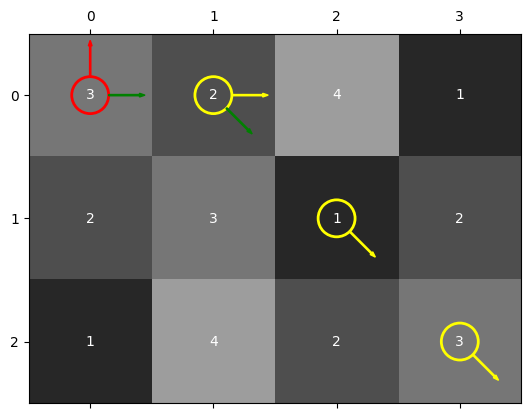

In [18]:
import numpy as np

_, _, map, _, _ = read_input_file("exampleMap.txt")
h2_cost, states = get_states_h2((0, 0, 0), (2, 3, 8))
print(f"Cost of heuristic 2: {h2_cost}")
print(f"States: {states}")
plot_path_in_map(
    np.array(map),
    initial_state=states[0],
    states=states,
)

### Plot the path followed by the robot with the different search algorithms


In [19]:
n_rows, n_cols, map, initial, goal = read_input_file("exampleMap.txt")
mp = MinningProblem(n_rows, n_cols, map, initial, (0, 2, 8))

mp.actions((0, 3, 5))

['turn_left', 'turn_right', 'move_forward']

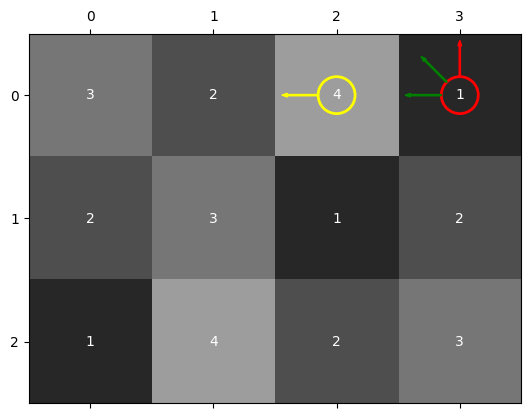

In [20]:
n_rows, n_cols, map, initial, goal = read_input_file("exampleMap.txt")
mp = MinningProblem(n_rows, n_cols, map, initial, (0, 2, 8))
sol = run_search_algorithm(mp, breadth_first_graph_search, verbose=False)
# Get the states of the solution
states = [node.state for node in sol.path()]  # we need to unpack the state
plot_path_in_map(
    np.array(map),
    initial_state=states[0],
    states=states,
)